In [8]:
# Imports

%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


In [2]:
def auto_corr(x,fm):

    T=1/fm 
    #por que no me andan los commits lpm
    pmin=50
    pmax=200

    Tmin=1/pmax
    Tmax=1/pmin

    nmin=int(math.floor(Tmin/T))
    nmax=int(math.ceil(Tmax/T))

    x_cor=np.correlate(x,x,mode='full')
    x_cor=x_cor[len(x):len(x_cor)]

    i=np.argmax(x_cor[nmin:nmax])

    npitch=i+nmin
    Tpitch=npitch*T

    Fpitch=1/Tpitch

    return Fpitch



4431
4431


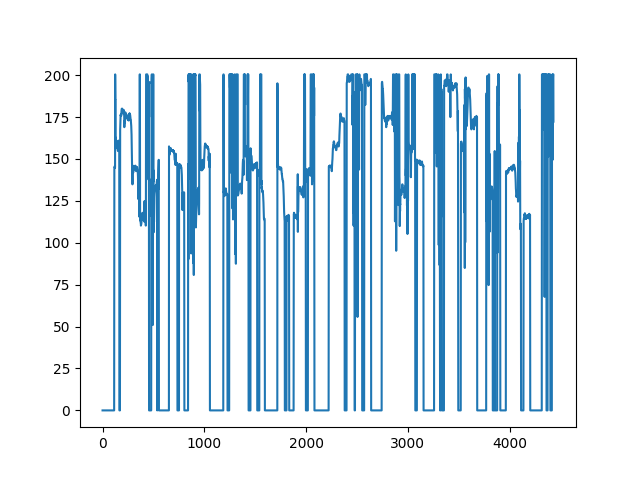

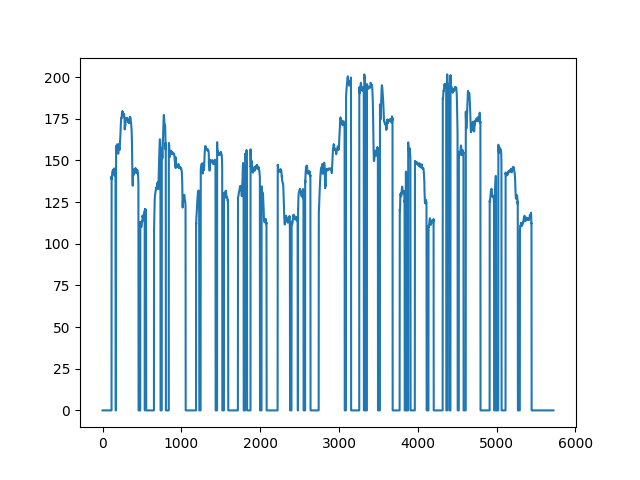

In [7]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

ref_aux=pd.read_csv('dataset_proyecto/vocadito_1_f0.csv',names=['f0','t'])

# list with each item representing a column
ref = []
for col in ref_aux:
    # convert pandas series to list
    col_ref = ref_aux[col].tolist()
    # append column list to ls
    ref.append(col_ref)
# print the created list

ref_f0=ref[1]
ref_t=ref[0]


tvent = 0.030
tstep = tvent*0.25


nvent = int(tvent*rate)
nstep = int(tstep*rate)

nframes=len(ref[0])
nframes=int((len(signal)-nvent-nvent/2-nstep)/nstep)

cant_vent = int((len(signal)/nvent))
vent = np.hamming(nvent)

ini=nvent//2
p_corr = np.zeros(nframes)
print(nframes)
print(len(p_corr))
for i in range(nframes):
    if ref_f0[i]>0:
        p_corr[i] = auto_corr(signal[ini:ini + nvent]*vent,rate)
    
    ini = ini + nstep

plt.close('all')
plt.plot(p_corr)
plt.show()

plt.figure()
plt.plot(ref_f0)
plt.show()
